In [1]:
import open3d as o3d
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# 生成模拟的管状结构点云
def generate_cylinder_point_cloud(radius=1.0, height=10.0, num_points=1000):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    z = np.random.uniform(0, height, num_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    points = np.vstack((x, y, z)).T
    return points

# 创建点云
points = generate_cylinder_point_cloud(radius=1.0, height=10.0, num_points=2000)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# # 显示点云
# o3d.visualization.draw_geometries([point_cloud])


## 确定起点和终点

In [23]:
import numpy as np
from scipy.optimize import leastsq
import open3d as o3d

# 使用PCA估计主轴方向
def estimate_main_axis(points):
    mean = np.mean(points, axis=0)
    centered_points = points - mean
    cov_matrix = np.cov(centered_points.T)
    eigvals, eigvecs = np.linalg.eig(cov_matrix)

    # 最大的特征值对应的特征向量是主轴方向
    main_axis = eigvecs[:, np.argmax(eigvals)]
    
    # 沿着主轴方向投影点云
    projections = points.dot(main_axis)
    
    # 获取投影后的最小值和最大值，作为两端
    start_point = points[np.argmin(projections)]  # 投影最小值对应的点
    end_point = points[np.argmax(projections)]  # 投影最大值对应的点
    
    return main_axis, mean, start_point, end_point

# 生成一个圆柱体模型
def generate_cylinder(radius, height, resolution=100):
    # 创建圆柱体的点
    theta = np.linspace(0, 2 * np.pi, resolution)
    z = np.linspace(-height / 2, height / 2, resolution)
    Z, T = np.meshgrid(z, theta)
    X = radius * np.cos(T)
    Y = radius * np.sin(T)
    points = np.vstack([X.flatten(), Y.flatten(), Z.flatten()]).T
    return points

# 计算旋转矩阵，将圆柱的主轴对齐到 z 轴
def rotate_to_z_axis(points, main_axis):
    # 目标方向是 z 轴
    t = np.array([0, 0, 1])
    
    # 计算旋转轴 u（主轴与 z 轴的叉积）
    u = np.cross(main_axis, t)
    
    # 如果 u 的模长为零，说明已经在 z 轴上，不需要旋转
    if np.linalg.norm(u) != 0:
        # 旋转角度 theta
        theta = np.arccos(np.dot(main_axis, t) / (np.linalg.norm(main_axis) * np.linalg.norm(t)))

        # 旋转矩阵（罗德里格旋转公式）
        u = u / np.linalg.norm(u)  # 归一化旋转轴
        ux, uy, uz = u
        R = np.array([
            [np.cos(theta) + ux**2 * (1 - np.cos(theta)), ux * uy * (1 - np.cos(theta)) - uz * np.sin(theta), ux * uz * (1 - np.cos(theta)) + uy * np.sin(theta)],
            [uy * ux * (1 - np.cos(theta)) + uz * np.sin(theta), np.cos(theta) + uy**2 * (1 - np.cos(theta)), uy * uz * (1 - np.cos(theta)) - ux * np.sin(theta)],
            [uz * ux * (1 - np.cos(theta)) - uy * np.sin(theta), uz * uy * (1 - np.cos(theta)) + ux * np.sin(theta), np.cos(theta) + uz**2 * (1 - np.cos(theta))]
        ])
        
        # 应用旋转矩阵
        rotated_points = np.dot(points, R.T)
    else:
        rotated_points = points
        
    return rotated_points


# 加载点云并提取平面上的点
pcd = o3d.io.read_point_cloud("s_pc_2.ply")
points = np.asarray(pcd.points)

# 假设点云已经投影到主轴垂直平面，获取主轴和质心
main_axis, _, _, _ = estimate_main_axis(points)


# 旋转圆柱体使主轴对齐到 z 轴
points = rotate_to_z_axis(points, main_axis)

# # 可视化原始圆柱和旋转后的圆柱
# # 原始圆柱
# original_cylinder = o3d.geometry.PointCloud()
# original_cylinder.points = o3d.utility.Vector3dVector(points)

# # 旋转后的圆柱
# rotated_cylinder = o3d.geometry.PointCloud()
# rotated_cylinder.points = o3d.utility.Vector3dVector(rotated_points)

# # 可视化
# o3d.visualization.draw_geometries([original_cylinder, rotated_cylinder], 
#                                   window_name="Cylinder Rotation",
#                                   point_show_normal=False)


# 假设点云已经投影到主轴垂直平面，获取主轴和质心
main_axis, centroid, start_point, end_point = estimate_main_axis(points)
print(main_axis)

# 拟合圆心
def calc_residuals(c, points):
    cx, cy = c
    # 计算点到圆心的距离
    residuals = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2)
    # 最小化每个点到圆的距离
    return residuals - np.mean(residuals)

# 使用最小二乘法拟合圆心并计算圆的半径
def fit_circle(points):
    # 使用最小二乘法拟合圆
    initial_guess = np.mean(points, axis=0)  # 初始猜测是点云的平均值
    fitted_circle_center, _ = leastsq(calc_residuals, initial_guess, args=(points,))
    
    # 计算圆的半径
    cx, cy = fitted_circle_center
    distances = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2)
    radius = np.mean(distances)  # 半径为所有点到圆心的平均距离
    
    return fitted_circle_center, radius

def project_to_plane(points, normal):
    # 计算投影矩阵
    normal = normal / np.linalg.norm(normal)
    projection_matrix = np.eye(3) - np.outer(normal, normal)
    projected_points = points @ projection_matrix.T
    return projected_points

# 计算点到平面的距离
def find_points_in_plane_circle(points, start_point, normal, radius=0.1):
    # 计算点到平面的距离
    vectors_to_plane = points - start_point  # 点到平面的向量
    distances_to_plane = np.abs(np.dot(vectors_to_plane, normal))  # 点到平面的距离
    
    # 只保留在平面上的点
    # 计算每个点到 start_point 的欧几里得距离
    distances = np.linalg.norm(points - start_point, axis=1)

    # 找到最小距离
    min_distance = distances[np.argsort(distances)[1]]

    thresh_r = min_distance * 5
    points_on_plane = points[distances_to_plane <= thresh_r]  # 设置一个小阈值来选择平面上的点
    
    return points_on_plane

# 获取圆形上的点（距离一定半径的点）
plane_points = find_points_in_plane_circle(points, start_point, main_axis, radius=0.1)

# 拟合平面上的圆
projected_points = project_to_plane(plane_points, main_axis)[:, :2]  # 只取前两个分量进行2D拟合
circle_center, circle_radiu = fit_circle(projected_points)

# 将拟合的圆心扩展回3D
fitted_center_3d = np.array([circle_center[0], circle_center[1], start_point[2]])

# 获取圆形上的点（距离一定半径的点）
end_plane_points = find_points_in_plane_circle(points, end_point, main_axis, radius=0.1)
# 拟合平面上的圆
end_projected_points = project_to_plane(end_plane_points, main_axis)[:, :2]  # 只取前两个分量进行2D拟合
end_circle_center, end_circle_radiu = fit_circle(end_projected_points)
# 将拟合的圆心扩展回3D
end_fitted_center_3d = np.array([end_circle_center[0], end_circle_center[1], end_point[2]])

# 可视化拟合的圆心和点云
points_pcd = o3d.geometry.PointCloud()
points_pcd.points = o3d.utility.Vector3dVector(points)

fitted_center_pcd = o3d.geometry.PointCloud()
fitted_center_pcd.points = o3d.utility.Vector3dVector([fitted_center_3d])

end_fitted_center_pcd = o3d.geometry.PointCloud()
end_fitted_center_pcd.points = o3d.utility.Vector3dVector([end_fitted_center_3d])

plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(plane_points)
start_pcd = o3d.geometry.PointCloud()
start_pcd.points = o3d.utility.Vector3dVector([start_point])

# 可视化点云和拟合结果
# o3d.visualization.draw_geometries([points_pcd, fitted_center_pcd, end_fitted_center_pcd])

[-2.36269651e-16 -1.40155503e-18  1.00000000e+00]


## 连接起点和终点，形成中轴线步长

In [20]:
# 生成圆柱的中轴线
def generate_axis_line(start_point, end_point, num_points=100):
    axis_line = np.linspace(start_point, end_point, num_points)
    return axis_line

axis_line = generate_axis_line(fitted_center_3d, end_fitted_center_3d)

In [ ]:
## 每个步长对应生成一个投影ping mian

In [21]:
center_line = []
center_radius = []
for axis_point in axis_line:
    # print(axis_point)
    # 获取圆形上的点（距离一定半径的点）
    plane_points = find_points_in_plane_circle(points, axis_point, main_axis, radius=0.1)

    # 拟合平面上的圆
    projected_points = project_to_plane(plane_points, main_axis)[:, :2]  # 只取前两个分量进行2D拟合
    circle_center, circle_radiu = fit_circle(projected_points)
    
    # 将拟合的圆心扩展回3D
    fitted_center_3d = np.array([circle_center[0], circle_center[1], axis_point[2]])
    center_line.append(fitted_center_3d)
    center_radius.append(circle_radiu)

center_pcd = o3d.geometry.PointCloud()
center_pcd.points = o3d.utility.Vector3dVector(center_line)

# 可视化点云和拟合结果
# o3d.visualization.draw_geometries([points_pcd, center_pcd])

/Users/apple/opt/anaconda3/envs/trace/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25311 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/apple/opt/anaconda3/envs/trace/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/apple/opt/anaconda3/envs/trace/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22278 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/apple/opt/anaconda3/envs/trace/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/apple/opt/anaconda3/envs/trace/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/app

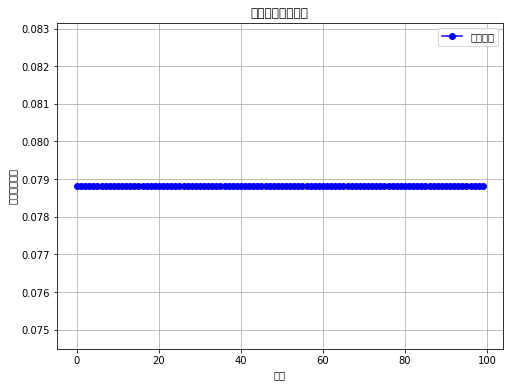

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# 绘制 center_radius 的分布
plt.figure(figsize=(8, 6))
plt.plot(center_radius, marker='o', linestyle='-', color='b', label='圆的半径')
plt.xlabel('索引')
plt.ylabel('拟合圆的半径')
plt.title('拟合圆的半径分布')
plt.legend()
plt.grid(True)
plt.show()